### 5.4.3　可视化类激活的热力图

我还要介绍另一种可视化方法，它有助于了解一张图像的哪一部分让卷积神经网络做出了
最终的分类决策。这有助于对卷积神经网络的决策过程进行调试，特别是出现分类错误的情况下。
这种方法还可以定位图像中的特定目标。

这种通用的技术叫作类激活图（CAM，class activation map）可视化，它是指对输入图像生
成类激活的热力图。类激活热力图是与特定输出类别相关的二维分数网格，对任何输入图像的
每个位置都要进行计算，它表示每个位置对该类别的重要程度。举例来说，对于输入到猫狗分
类卷积神经网络的一张图像，CAM 可视化可以生成类别“猫”的热力图，表示图像的各个部分
与“猫”的相似程度，CAM 可视化也会生成类别“狗”的热力图，表示图像的各个部分与“狗”
的相似程度。

我们将使用的具体实现方式是“Grad-CAM: visual explanations from deep networks via gradientbased
localization”a 这篇论文中描述的方法。这种方法非常简单：给定一张输入图像，对于一个
卷积层的输出特征图，用类别相对于通道的梯度对这个特征图中的每个通道进行加权。直观上
来看，理解这个技巧的一种方法是，你是用“每个通道对类别的重要程度”对“输入图像对不
同通道的激活强度”的空间图进行加权，从而得到了“输入图像对类别的激活强度”的空间图。

In [1]:
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
model = VGG16(weights='imagenet')#注意，网络中包括了密集连接分类器。在前面所有的例子中，我们都舍弃了这个分类器

W0805 11:22:00.947731 139844095641472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 11:22:01.005688 139844095641472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 11:22:01.015263 139844095641472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 11:22:01.092295 139844095641472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 5s 0us/step


W0805 11:22:07.625459 139844095641472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0805 11:22:07.626680 139844095641472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [4]:
!ls ~/.keras/models/

vgg16_weights_tf_dim_ordering_tf_kernels.h5


In [0]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input , decode_predictions
import numpy as np


In [0]:
img_path = '/content/drive/My Drive/data/cats_and_dogs_small/test/cats/cat.1735.jpg' #目标图像的路径

img = image.load_img(img_path, target_size=(224,224))#大小为224×224 的Python图像库（PIL，Python imaginglibrary）图像

x = image.img_to_array(img) #形 状 为 (224, 224, 3) 的float32 格式的Numpy 数组
x = np.expand_dims(x, axis=0) #添加一个维度，将数组转换为(1, 224, 224, 3) 形状的批量
x = preprocess_input(x) #对批量进行预处理（按通道进行颜色标准化)

现在你可以在图像上运行预训练的VGG16 网络，并将其预测向量解码为人类可读的格式。

In [10]:
preds = model.predict(x)
print('Predicted:',decode_predictions(preds,top=3)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02124075', 'Egyptian_cat', 0.12910204), ('n03950228', 'pitcher', 0.0616345), ('n02123045', 'tabby', 0.053694747)]


对这张图像预测的前三个类别分别为：


*   Egyptian_cat  12.9%的概率
*   pitcher  6%的概率
*   tabby  5%的概率

网络识别出图像中包含数量不确定的猫。预测向量中被最大激活的元素是对应“猫”
类别的元素，索引编号为285。

In [11]:
np.argmax(preds[0])

285

为了展示图像中哪些部分最像猫，我们来使用Grad-CAM 算法。

In [0]:
from keras import backend as K

In [0]:
african_cat_output = model.output[:,285] #预测向量中的“猫”元素

last_conv_layer = model.get_layer('block5_conv3')# block5_conv3层的输出特征图，它是VGG16的最后一个卷积层

#'猫'类别相对于block5_conv3输出特征图的梯度
grads = K.gradients(african_cat_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0,1,2))#形状为(512,)的向量，每个元素是特定特征图通道的梯度平均大小

#访问刚刚定义的量：对于给定的样本图像，pooled_grads 和block5_conv3 层的输出特征图
iterate = K.function([model.input],
                    [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x]) #对于两个猫的样本图像,这两个向量都是Numpy数组

for  i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]  #将特征图数组的每个通道乘以“这个通道对‘猫’类别的重要程度”
  
heatmap = np.mean(conv_layer_output_value, axis=-1)#得到的特征图的逐通道平均值即为类激活的热力图

为了便于可视化，我们还需要将热力图标准化到0~1 范围内。得到的结果如图5-35 所示。

In [0]:
import matplotlib.pyplot as plt

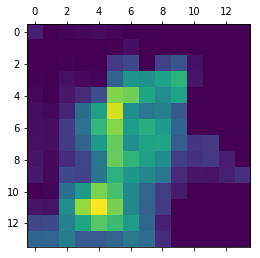

In [16]:
heatmap = np.maximum(heatmap ,0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

最后，我们可以用OpenCV 来生成一张图像，将原始图像叠加在刚刚得到的热力图上（见
图5-36）。

In [0]:
import cv2

In [19]:
img = cv2.imread(img_path) #用cv2加载原始图像
heatmap = cv2.resize(heatmap,(img.shape[1],img.shape[0]))#将热力图的大小调整为与原始图像相同
heatmap = np.uint8(255 * heatmap) #将热力图转换为RGB格式
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)# 将热力图应用于原始图像
superimposed_img = heatmap * 0.4 + img #这里的0.4是热力图强度因子
cv2.imwrite('/content/drive/My Drive/data/cat_cam.jpg',superimposed_img)

True

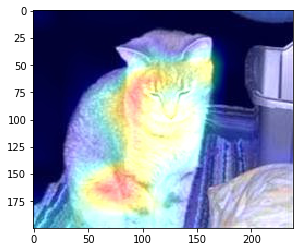

In [20]:
img_new = plt.imread('/content/drive/My Drive/data/cat_cam.jpg')
plt.imshow(img_new)
plt.show()

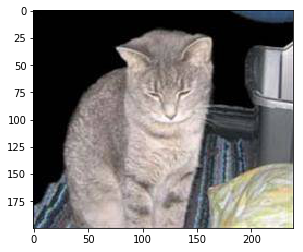

In [21]:
img_old = plt.imread(img_path)
plt.imshow(img_old)
plt.show()

这种可视化方法回答了两个重要问题：
* 网络为什么会认为这张图像中包含一只猫？
* 猫在图像中的什么位置？
尤其值得注意的是，猫头部和脚部的激活强度很大，这可能是网络找到的猫的不同之处。